In [2]:
import pandas as pd
import string
import re
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [3]:
STOPWORDS = set(stopwords.words('english'))

In [4]:
def clean(data):
    from nltk.stem.snowball import SnowballStemmer
    
    stemmer = SnowballStemmer("english")
    data=data.lower()
    data = re.sub('\[.*?\]','',data)
    data = re.sub("\\W", " ", data)
    data = re.sub('https?://\S+|www\.\S+', '', data)
    data = re.sub('<.*?>+', '', data)
    data = re.sub('[%s]' % re.escape(string.punctuation), '', data)
    data = re.sub('\n', '', data)
    data = re.sub('\w*\d\w*', '', data)
    data = ' '.join(stemmer.stem(word) for word in data.split() if word not in STOPWORDS)
    return data

In [5]:
politifact = pd.read_json(r'./data/politifact.json')
snopes = pd.read_json(r'./data/snopes.json')
poli_cols = politifact.columns.to_list()
snopes_col = snopes.columns.to_list()

In [6]:
# Merge two tables and drop the nulls

temp = poli_cols+snopes_col
temp_set = set(temp)
data_cols = ['claim','doc','topic','label']
df = pd.concat([politifact[data_cols],snopes[data_cols]], ignore_index=True)
df = df.sample(frac=1, ignore_index=True)
df =df.dropna(subset=['doc','claim','label'])

In [7]:
df['new_topic']=[' '.join(y) for y in (x for x in df['topic'])]

In [8]:
df['body'] = df['new_topic']+' '+df['claim']+df['doc']

In [9]:
# %%timeit

df['body'] = df['body'].apply(clean)

In [21]:
df.to_csv(r'.\data\parsed_data.csv')

In [22]:
df['label'] = df['label'].apply(lambda x: x.lower())

true_labels = ['correct attribution','mostly true','mostly-true', 'true',]
false_labels = ['false','mostly false','pants-fire',]
temp=[]
for index in range(len(df)):
    if df['label'][index] in true_labels:
        temp.append(0)
    elif df['label'][index] in false_labels:
        temp.append(1)
    else:
        temp.append(2)
        
df['new_label']=temp

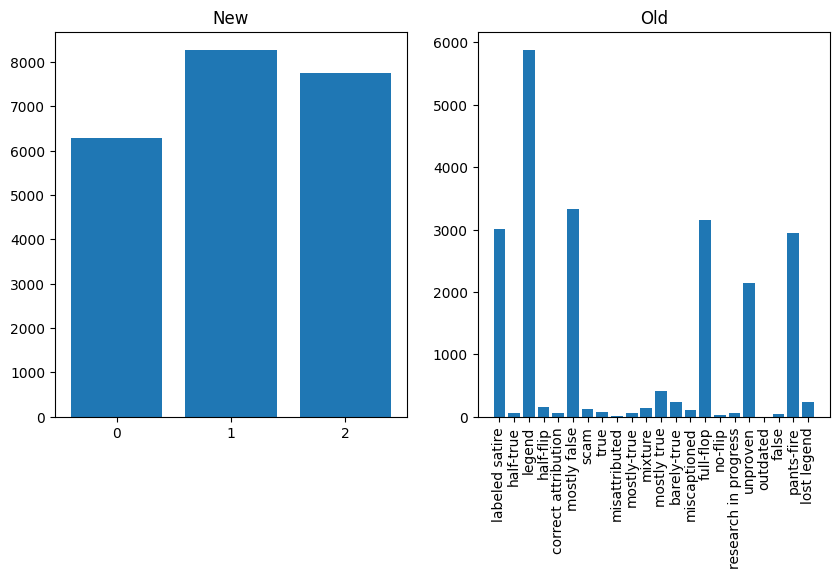

In [23]:
# %matplotlib inline

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))

ld = df.groupby(by='label').size()
new_ld = df.groupby(by='new_label').size()



ax2.bar(list(set(df['label'].tolist())), ld)
ax2.set_title('Old')


ax1.bar(['0','1','2'], new_ld)
ax1.set_title('New')


plt.xticks(rotation='vertical')
plt.show()

In [24]:
# splitting train and test data
x=df['body']

x_train, x_test, y_train, y_test = train_test_split(df['body'],df['new_label'],test_size = 0.20)#, random_state = 42)

In [25]:
# vectorizing the body column using tfidf method
tfidf_vectorizer = TfidfVectorizer()
final_x_train = tfidf_vectorizer.fit_transform(x_train)
final_x_test = tfidf_vectorizer.transform(x_test)

In [27]:
# training logestic Regression model
logestic_r = LogisticRegression(multi_class='multinomial', solver='newton-cg')
logestic_r.fit(final_x_train,y_train)

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [28]:
# predicting values for test data
lr_pred = logestic_r.predict(final_x_test)

In [29]:
# Random forest model

rf = RandomForestClassifier(random_state=42)
rf.fit(final_x_train,y_train)
rf_pred = rf.predict(final_x_test)

In [30]:
# Ensemble model
ensemble = VotingClassifier(estimators=[('lr', logestic_r), ('rf', rf)], voting='hard')
ensemble.fit(final_x_train,y_train)
ensemble_pred = ensemble.predict(final_x_test)

In [31]:
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
print("Logistic Regression Precision:", precision_score(y_test, lr_pred, average='macro'))
print("Logistic Regression Recall:", recall_score(y_test, lr_pred, average='macro'))
print("Logistic Regression F1 Score:", f1_score(y_test, lr_pred, average='macro'))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("Random Forest Precision:", precision_score(y_test, rf_pred, average='macro'))
print("Random Forest Recall:", recall_score(y_test, rf_pred, average='macro'))
print("Random Forest F1 Score:", f1_score(y_test, rf_pred, average='macro'))
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_pred))
print("Ensemble Precision:", precision_score(y_test, ensemble_pred, average='macro'))
print("Ensemble Recall:", recall_score(y_test, ensemble_pred, average='macro'))
print("Ensemble F1 Score:", f1_score(y_test, ensemble_pred, average='macro'))

Logistic Regression Accuracy: 0.6544843049327355
Logistic Regression Precision: 0.654707597474142
Logistic Regression Recall: 0.6502899866448212
Logistic Regression F1 Score: 0.6518127414211582
Random Forest Accuracy: 0.692152466367713
Random Forest Precision: 0.7088864189936083
Random Forest Recall: 0.6854206725913284
Random Forest F1 Score: 0.6895312727366587
Ensemble Accuracy: 0.6809417040358744
Ensemble Precision: 0.6792878167780204
Ensemble Recall: 0.6787180012546656
Ensemble F1 Score: 0.6745395207991294


In [84]:
# [np.where(x == 1)[0][0] for x in y_test]
print(y_test_binarized.argmax(axis=1))
print(ensemble_pred)

[2 0 1 ... 2 2 0]
[2 2 1 ... 0 0 0]


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Confusion matrix
y_test_binarized = label_binarize(y_test, classes=[0,1,2])
cm = confusion_matrix(y_test_binarized.argmax(axis=1), ensemble_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[ 961  169  190]
 [ 184 1294  180]
 [ 307  393  782]]


In [33]:
# Classification report
print("Classification Report:") 
print(classification_report(y_test, ensemble_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.73      0.69      1320
           1       0.70      0.78      0.74      1658
           2       0.68      0.53      0.59      1482

    accuracy                           0.68      4460
   macro avg       0.68      0.68      0.67      4460
weighted avg       0.68      0.68      0.68      4460



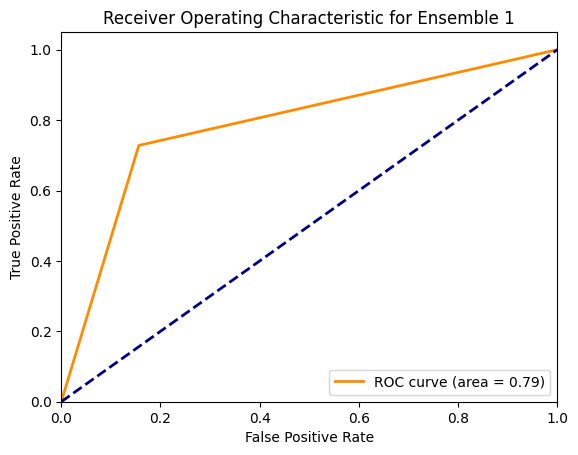

In [34]:
# ROC Curve
lb = LabelBinarizer()
lb.fit(y_test)
y_t = lb.transform(y_test)
e_pred = lb.transform(ensemble_pred)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(lb.classes_.size):
    fpr[i], tpr[i], _ = roc_curve(y_t[:, i], e_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Ensemble 1')
plt.legend(loc="lower right")
plt.show()

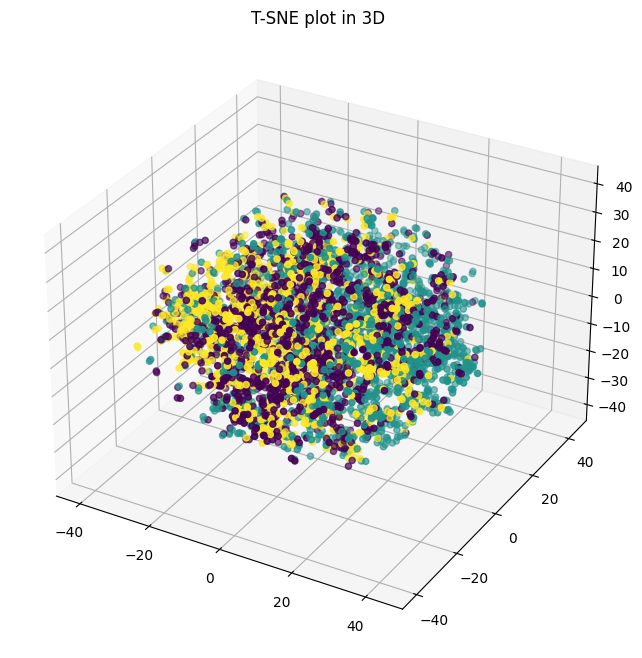

In [38]:
# T-SNE plot
from mpl_toolkits.mplot3d import Axes3D

tsne = TSNE(n_components=3, init="random",perplexity=30)
X_tsne = tsne.fit_transform(final_x_test)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=ensemble_pred)
ax.set_title('T-SNE plot in 3D')
plt.show()
